# Important Note
RAM and VRAM measurements are dependent on the computer state, and should only be interpreted relative to each other. In order to obtain RAM and VRAM measurements, perform the following steps as normal but only use the first ram and vram measurements. Additionally, the Datagenerator.rmd file must be run to generate the data first.

# Instructions

This notebook provides code to implement and benchmark the HSSVD method using the compact Matern kernel in 2D. To run this benchmark, perform the following steps:

Step 1: Run the following cell to import the required packages and helper functions. Set the number of replicates desired.

Step 2: Load the Data and implement the method

Step 3: Execute the benchmark

# Step 1: Loading Required Packages and Helper Functions


In [1]:
# --- Reproducibility / Config ---
n_replicates = 2

# --- Built-in Imports ---
import os
import math
import time
import gc
import statistics

# --- Third-Party Core Packages ---
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import psutil
import pynvml
from tqdm import tqdm, trange
from scipy.io import loadmat

# --- GPyTorch Modules ---
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.variational.nearest_neighbor_variational_strategy import NNVariationalStrategy
from gpytorch.mlls import DeepApproximateMLL
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

# --- PyTorch Utilities ---
from torch.utils.data import TensorDataset, DataLoader

# --- Print Versions ---
print(torch.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(psutil.__version__)
print(gpytorch.__version__)

# --- Inline Settings (Jupyter only) ---
# Only run these in an IPython/Jupyter environment
try:
    get_ipython().run_line_magic("matplotlib", "inline")
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
except:
    pass  # Not in IPython

# --- GPU & Memory Logging ---
max_vram = 0
max_ram = 0

def vram_usage():
    global max_vram
    max_vram = max(max_vram, torch.cuda.memory_allocated())

def log_memory():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    meminfo = pynvml.nvmlDeviceGetMemoryInfo(handle)
    
    gpu_used = meminfo.used / 1024**2  # MB
    torch_allocated = torch.cuda.max_memory_allocated() / 1024**2  # MB
    sys_used = psutil.virtual_memory().used / 1024**3  # GB
    
    print(f"[GPU] Used: {gpu_used:.2f} MB")
    print(f"[PyTorch] Max Allocated: {torch_allocated:.2f} MB")
    print(f"[System RAM] Used: {sys_used:.2f} GB")
    
    return gpu_used, torch_allocated, sys_used

def get_mem():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss


2.6.0+cu118
1.26.4
3.9.2
5.9.0
1.13


# Step 2: Load the Data and implement the method

In [ ]:
csvfile = pd.read_csv('Data/data_2d.csv', header = None, dtype=float, delimiter=',')
all_data = torch.tensor(np.array(csvfile)).float()

def splitter(all_data, n_train=80_000, n_test=20_000, random_state=42, move_to_gpu=True):
    assert all_data.ndim == 2 and all_data.shape[1] == 3, \
        "all_data must be [N,3]"
    total_samples = all_data.shape[0]
    assert n_train + n_test <= total_samples, "Not enough samples to split"
    rng = np.random.default_rng(seed=random_state)
    indices = rng.permutation(total_samples)
    train_idx = indices[:n_train]
    test_idx  = indices[n_train:n_train + n_test]
    train = all_data[train_idx]
    test  = all_data[test_idx]
    train_x = train[:, :2].contiguous()
    train_y = train[:,  2].contiguous()
    test_x  = test[:,  :2].contiguous()
    test_y  = test[:,   2].contiguous()

    if move_to_gpu and torch.cuda.is_available():
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        test_x  = test_x.cuda()
        test_y  = test_y.cuda()

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = splitter(all_data, n_train= 80_000, n_test = 20_000, random_state=42, move_to_gpu=True)
print(train_x.shape)
print(train_x.size(-1))
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([80000, 2])
2
torch.Size([80000])
torch.Size([20000, 2])
torch.Size([20000])


## Implementing the method

In [9]:
import torch
import torch.optim as optim

def phifunc(m, x):
    device = x.device
    dtype = x.dtype
    n = x.shape[0]
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    sin1 = torch.sin(torch.pi * freq.unsqueeze(1) * x[:, 0].unsqueeze(0))
    sin2 = torch.sin(torch.pi * freq.unsqueeze(1) * x[:, 1].unsqueeze(0))
    sin1_t = sin1.transpose(0, 1)
    sin2_t = sin2.transpose(0, 1)
    phi = (sin1_t.unsqueeze(2) * sin2_t.unsqueeze(1)).reshape(n, -1)
    return phi

def lambdafunc(m, eps, beta):
    device = eps.device
    dtype = eps.dtype
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    I2 = (freq.unsqueeze(1)**2 + freq.unsqueeze(0)**2)
    lam = ((torch.pi**2) * I2 + eps**2)**(-beta)
    lam = lam.reshape(-1)
    lam = lam / torch.max(lam)
    return lam

def hssvd_predict_2d(x, y, x_new, init=torch.tensor([0.0, 0.0]), m=30, beta=1, 
                     train=True, lr=0.01, max_iter=1000, tol=1e-6):
    device = x.device
    dtype = x.dtype
    print(device)
    print(dtype)
    init = init.to(device=device, dtype=dtype)
    print(torch.cuda.memory_allocated() / (1024 ** 2), "MB allocated")
    n = x.shape[0]
    Phi = phifunc(m, x)
    MM = Phi.shape[1]
    phi_T_phi = Phi.t() @ Phi
    phi_T_y = Phi.t() @ y
    sum_y2 = torch.sum(y**2)
    print(torch.cuda.memory_allocated() / (1024 ** 2), "MB allocated")

    def nlik(log_params):
        eps = torch.exp(log_params[0])
        s2  = torch.exp(log_params[1])
        Lambda = lambdafunc(m, eps, beta)
        A = s2 * torch.diag(1.0 / Lambda) + phi_T_phi + 1e-10 * torch.eye(MM, device=device, dtype=dtype)
        L = torch.linalg.cholesky(A)
        sol = torch.cholesky_solve(phi_T_y.unsqueeze(1), L).squeeze(1)
        t1 = (sum_y2 - (phi_T_y @ sol)) / s2
        logdetA = 2 * torch.sum(torch.log(torch.diag(L)))
        t2 = (n - m) * torch.log(s2) + logdetA
        t3 = torch.sum(torch.log((Lambda)))
        return t1 + t2 + t3

    if train:
        print(torch.cuda.memory_allocated() / (1024 ** 2), "MB allocated")
        log_params = init.clone().detach().requires_grad_(True)
        optimizer = optim.Adam([log_params], lr=lr)
        prev_loss = None
        for iter_ in range(max_iter):
            optimizer.zero_grad()
            loss = nlik(log_params)
            loss.backward()
            optimizer.step()
            print(f"Iter {iter_}: estimate = {log_params.data}, loss = {loss.item():.4f}", end="\r")
            if prev_loss is not None and torch.abs(loss - prev_loss) < tol*n:
                print(f"\nConverged after {iter_} iterations")
                break
            prev_loss = loss.item()
        out = log_params.detach()
        print("\nOptimized parameters (log-space):", out)
        print(torch.cuda.memory_allocated() / (1024 ** 2), "MB allocated")
    else:
        out = init

    eps  = torch.exp(out[0])
    s2   = torch.exp(out[1])
    Lambda = lambdafunc(m, eps, beta)
    print(torch.cuda.memory_allocated() / (1024 ** 2), "MB allocated")
    A_final = s2 * torch.diag(1.0 / Lambda) + phi_T_phi + 1e-10 * torch.eye(MM, device=device, dtype=dtype)
    L_final = torch.linalg.cholesky(A_final)
    sol_final = torch.cholesky_solve(phi_T_y.unsqueeze(1), L_final).squeeze(1)
    K_inv_y = (1.0 / s2) * (y - Phi @ sol_final)
    print(torch.cuda.memory_allocated() / (1024 ** 2), "MB allocated")
    Phi_new = phifunc(m, x_new)
    y_new = Phi_new @ (torch.diag(Lambda) @ (Phi.t() @ K_inv_y))
    print("log memory")
    print(log_memory())
    return y_new


# Step 3: Execute the benchmark
To use GPU, set gpu = True. To use CPU only, set gpu = False.

In [24]:
import torch
import time
import psutil
import pandas as pd

#################################################################################
#      Set gpu = True to use GPU, False to use CPU only
#################################################################################
gpu = True


dtype = torch.float64 if not gpu else torch.float32
device = torch.device('cuda') if gpu else torch.device('cpu')

init = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
m = 25
beta = 2.5
lr = 0.1
num_repeats = 11

results = []
process = psutil.Process()

for i in range(num_repeats):
    print(f"\n=== Replicate {i+1}/{num_repeats} ===")
    train_x, train_y, test_x, test_y = splitter(all_data, n_train=400_000, n_test=20_000, random_state=i, move_to_gpu=gpu)

    if not gpu:
        train_x = train_x.double()
        train_y = train_y.double()
        test_x = test_x.double()
        test_y = test_y.double()
    else:
        if test_y.is_cuda:
            test_y = test_y.cpu()

    ram_before = process.memory_info().rss / (1024 ** 2)
    torch.cuda.reset_max_memory_allocated(device=None)
    start_time = time.time()
    y_pred = hssvd_predict_2d(train_x, train_y, test_x, init=init, m=m, beta=beta, train=True, lr=lr)
    elapsed_time = time.time() - start_time
    if y_pred.is_cuda:
        y_pred = y_pred.cpu()

    if test_y.is_cuda:
        test_y = test_y.cpu()

    mse = torch.mean((y_pred - test_y) ** 2).item()

    ram_after = process.memory_info().rss / (1024 ** 2)
    ram_used = ram_after - ram_before

    results.append((elapsed_time, mse, ram_used))
    print(f"Time = {elapsed_time:.4f}s, MSE = {mse:.6f}, RAM Used = {ram_used:.2f}MB")


df = pd.DataFrame(results, columns=["Time (s)", "MSE", "RAM Used (MB)"])
display(df)
df.to_csv("hssvd_splitter_benchmark.csv", index=False)
print("Results saved to 'hssvd_splitter_benchmark.csv'")



=== Replicate 1/11 ===
cuda:0
torch.float32
20.98095703125 MB allocated
976.47412109375 MB allocated
976.47412109375 MB allocated


c:\ProgramData\miniconda3\envs\scaleGP\lib\site-packages\torch\cuda\memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Iter 78: estimate = tensor([ 2.0554, -2.3372], device='cuda:0'), loss = -521263.5000
Converged after 78 iterations

Optimized parameters (log-space): tensor([ 2.0554, -2.3372], device='cuda:0')
976.4765625 MB allocated
976.47998046875 MB allocated
980.98876953125 MB allocated
log memory
[GPU] Used: 15353.05 MB
[PyTorch] Max Allocated: 1051.28 MB
[System RAM] Used: 40.80 GB
(15353.05078125, 1051.275390625, 40.79637908935547)
Time = 0.6354s, MSE = 0.100596, RAM Used = 0.25MB

=== Replicate 2/11 ===
cuda:0
torch.float32
20.98095703125 MB allocated
976.47412109375 MB allocated
976.47412109375 MB allocated
Iter 78: estimate = tensor([ 2.0642, -2.3362], device='cuda:0'), loss = -520850.0625
Converged after 78 iterations

Optimized parameters (log-space): tensor([ 2.0642, -2.3362], device='cuda:0')
976.4765625 MB allocated
976.47998046875 MB allocated
980.98876953125 MB allocated
log memory
[GPU] Used: 15342.92 MB
[PyTorch] Max Allocated: 1051.28 MB
[System RAM] Used: 40.81 GB
(15342.91796875

,Time (s),MSE,RAM Used (MB)
0,0.635389,0.100596,0.250000
1,0.272516,0.100284,0.003906
2,0.266807,0.100718,0.000000
3,0.277018,0.099819,0.000000
4,0.265200,0.101638,0.000000
5,0.267757,0.099247,0.000000
6,0.271490,0.100392,0.000000
7,0.379624,0.101960,0.000000
8,0.274016,0.099381,0.000000
9,0.265239,0.102741,0.000000


Results saved to 'hssvd_splitter_benchmark.csv'


In [ ]:
import numpy as np
results_array = np.array(results)

time_values = results_array[1:, 0]
mse_values = results_array[1:, 1]

time_mean = np.mean(time_values)
time_sd = np.std(time_values, ddof=1)

mse_mean = np.mean(mse_values)
mse_sd = np.std(mse_values, ddof=1)

print(f"Time: Mean = {time_mean:.4f}s, SD = {time_sd:.4f}s")
print(f"MSE: Mean = {mse_mean:.6f}, SD = {mse_sd:.6f}")


Time: Mean = 0.2800s, SD = 0.0320s
MSE: Mean = 0.100551, SD = 0.001210


# Optional Visualizations
This chunk provide visualizations for the fitted model. First it fits a model with the specified parameters, then it plots the fitted points colored by their fitted values.

cpu
torch.float32
16.25 MB allocated
16.25 MB allocated
16.25 MB allocated
Iter 78: estimate = tensor([ 2.0640, -2.3362]), loss = -520849.9062
Converged after 78 iterations

Optimized parameters (log-space): tensor([ 2.0640, -2.3362])
16.25 MB allocated
16.25 MB allocated
16.25 MB allocated
log memory
[GPU] Used: 15323.36 MB
[PyTorch] Max Allocated: 9361.90 MB
[System RAM] Used: 43.17 GB
(15323.35546875, 9361.90185546875, 43.174129486083984)


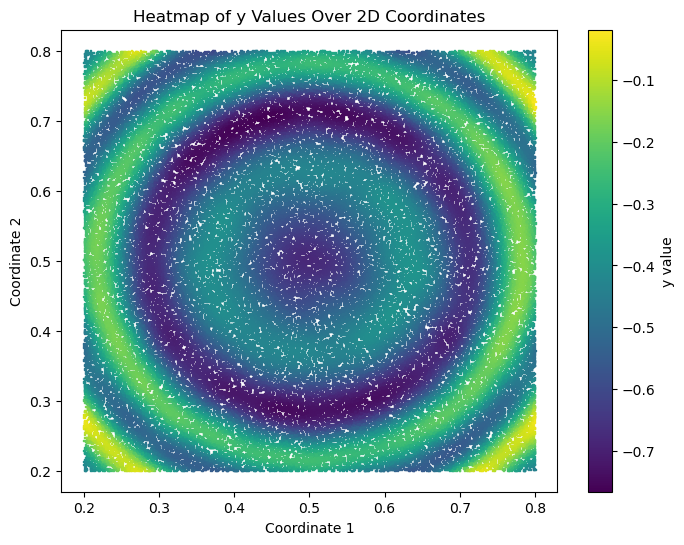

In [23]:
import matplotlib.pyplot as plt
import numpy as np


gpu = False
init = torch.tensor([0.0, 0.0], dtype=torch.double)
m = 25
beta = 2.5
lr = 0.1
num_repeats = 1

train_x, train_y, test_x, test_y = splitter(all_data, n_train=400000, n_test=80000, random_state=1, move_to_gpu=gpu)
y_pred = hssvd_predict_2d(train_x, train_y, test_x, init=init, m=m, beta=beta, train=True, lr=lr)
# Move predictions to CPU if needed
if y_pred.is_cuda:
    y_pred = y_pred.cpu()

    # Ensure test_y is also on CPU before MSE calculation
if test_y.is_cuda:
    test_y = test_y.cpu()


# Convert tensors to NumPy arrays (handles both CPU and GPU tensors)
x_coords = test_x.cpu().numpy() if test_x.is_cuda else test_x.numpy()
y_coords = y_pred

plt.figure(figsize=(8, 6))
# Scatter plot: the marker size (s) and marker style ('s' for square) can be adjusted as needed
sc = plt.scatter(x_coords[:, 0], x_coords[:, 1], c=y_coords, cmap='viridis', marker='s', s=1)
plt.colorbar(sc, label='y value')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Heatmap of y Values Over 2D Coordinates')
plt.show()